# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We start with a simple model here:

\begin{align}
\tau^2 & \sim P(\cdot) \\
\gamma_g &  \sim \mathcal{N}(0, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Log-Norm}(0, .1) \\
\sigma_2 & \sim \text{Half-Cauchy}(0, 1) \\
\alpha & \propto 1 \\
x_{vgs} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vgs} \cdot \exp \left(\alpha +  \beta_{vg} \right) \right) \\
\end{align}

In [75]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano.tensor as tt

In [51]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False}
)

In [3]:
np.random.seed(23) 

In [5]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

In [6]:
component = np.random.choice(MU.size, size=N, p=W)

In [9]:
x = np.random.normal(MU[component], SIGMA[component], size=N)

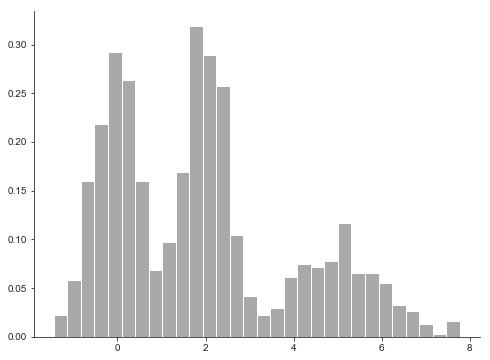

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=30, density=True, lw=1, color="darkgrey");

In [37]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))
    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)
    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [66]:
with model:
    trace = pm.sample(5000, init='advi', chains=2,
                      n_init=10000, tune=1000, random_seed=383561)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,189: 100%|██████████| 10000/10000 [00:07<00:00, 1373.97it/s] 
Finished [100%]: Average Loss = 2,188.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu, w]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:37<00:00, 324.27draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


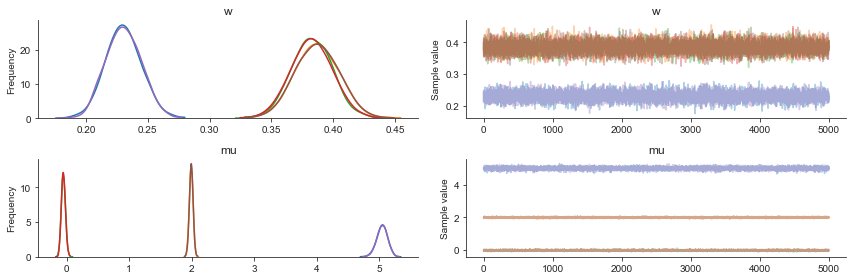

In [67]:
pm.traceplot(trace, varnames=['w', 'mu']);

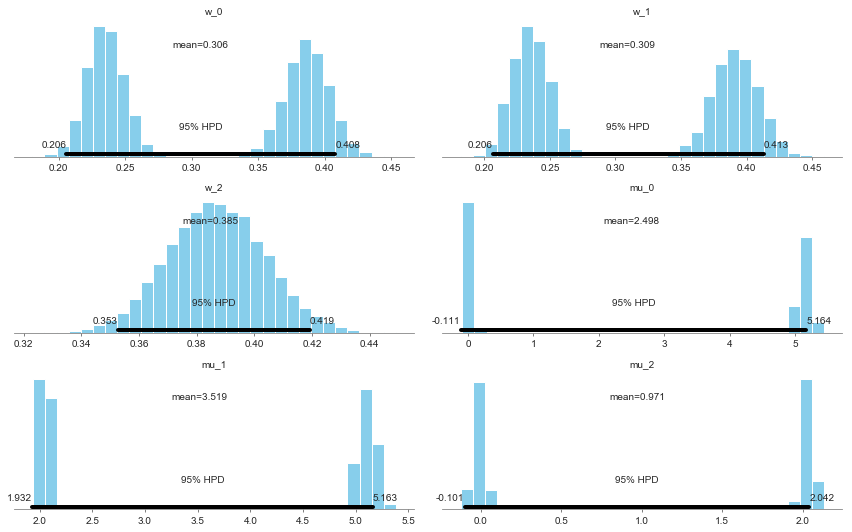

In [68]:
pm.plot_posterior(trace, varnames=['w', 'mu']);

In [69]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000, random_seed=23)

100%|██████████| 5000/5000 [00:05<00:00, 904.48it/s]


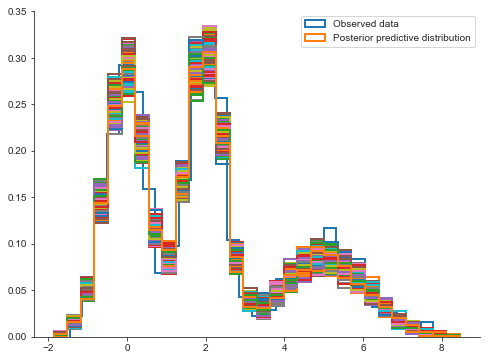

In [70]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, density=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

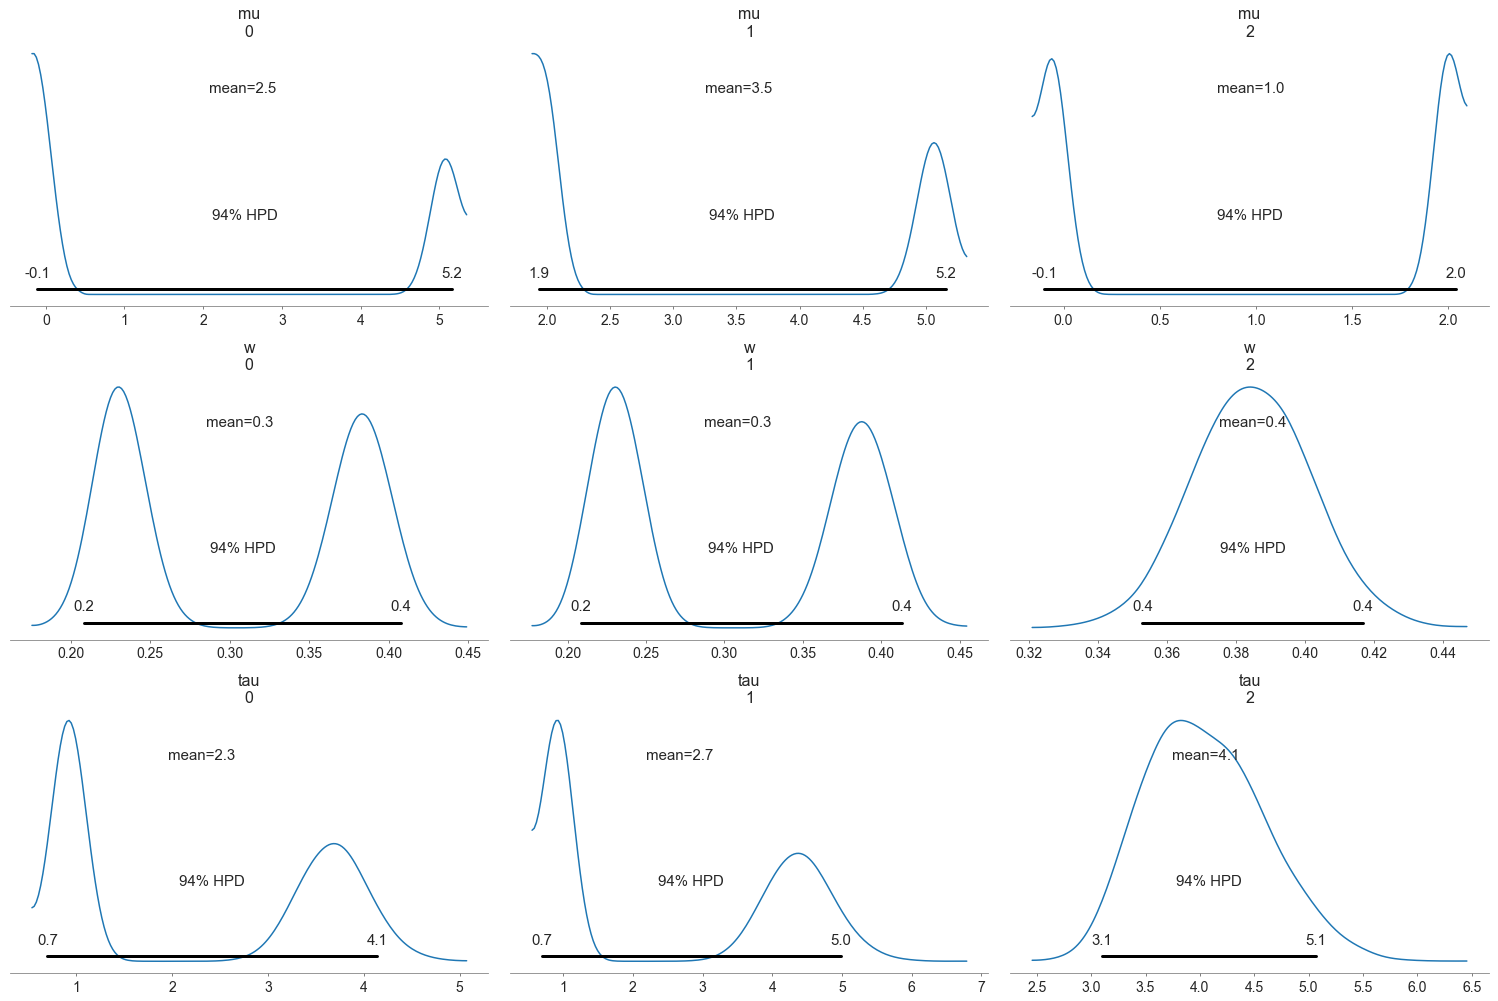

In [71]:
az.plot_posterior(trace, varnames=['w', 'mu']);

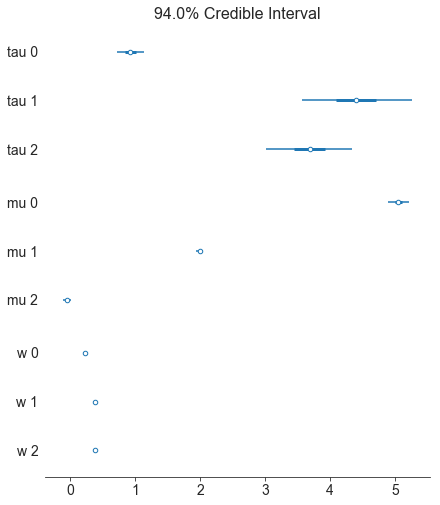

In [63]:
az.plot_forest(trace);

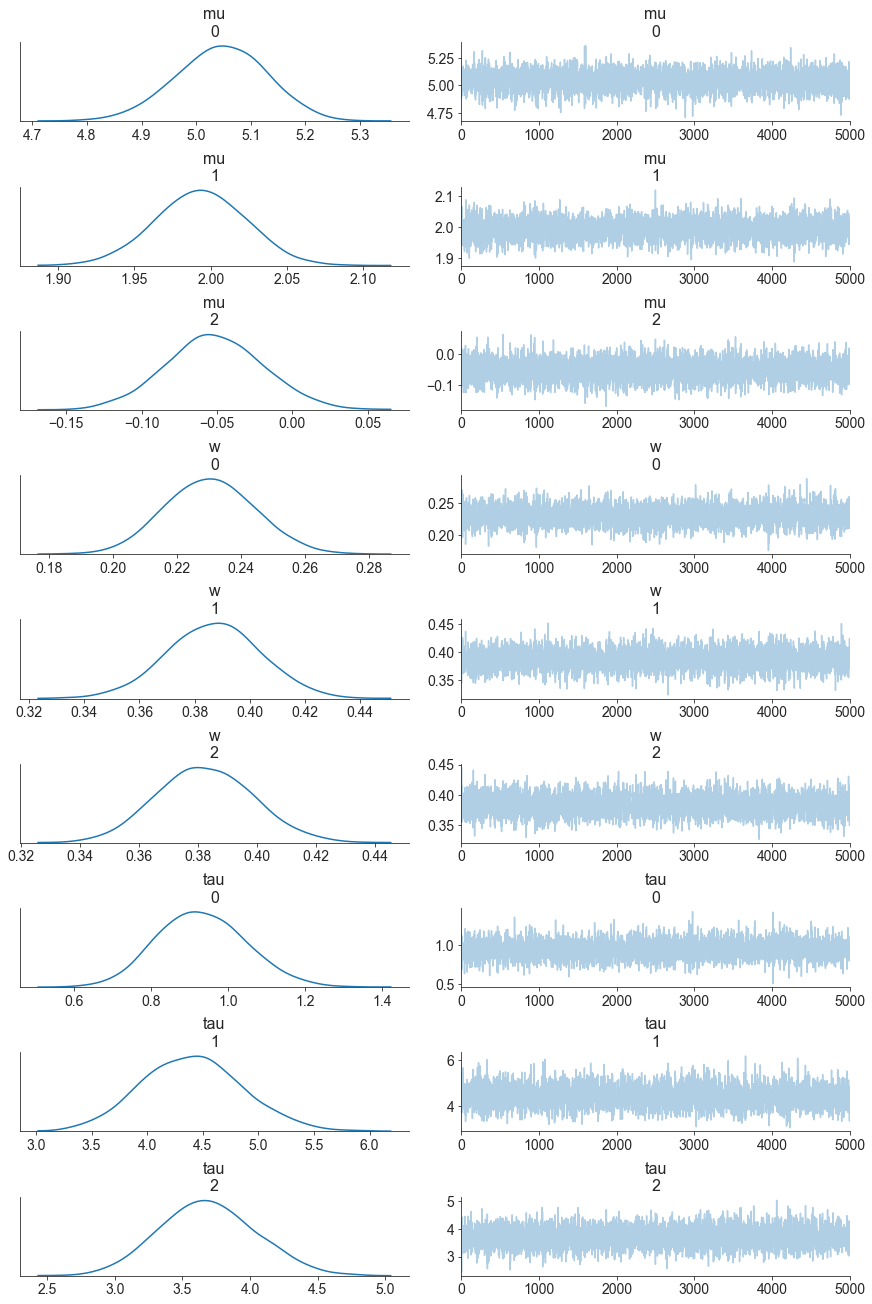

In [64]:
az.plot_trace(trace);

In [72]:
az.effective_sample_size(trace)

<xarray.Dataset>
Dimensions:    (mu_dim_0: 3, tau_dim_0: 3, w_dim_0: 3)
Coordinates:
  * mu_dim_0   (mu_dim_0) int64 0 1 2
  * w_dim_0    (w_dim_0) int64 0 1 2
  * tau_dim_0  (tau_dim_0) int64 0 1 2
Data variables:
    mu         (mu_dim_0) float64 1.0 1.0 1.0
    w          (w_dim_0) float64 1.0 1.0 185.0
    tau        (tau_dim_0) float64 1.0 1.0 1.0

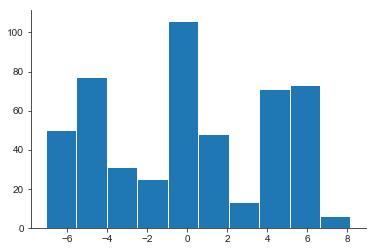

In [73]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [76]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [79]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd]
>>Metropolis: [p]
>ElemwiseCategorical: [category]
Sampling 2 chains: 100%|██████████| 21000/21000 [01:34<00:00, 222.82draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


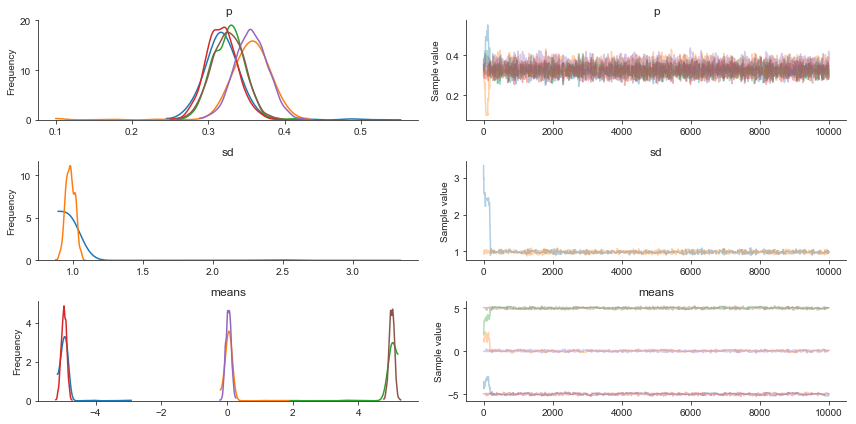

In [81]:
pm.traceplot(tr, ['p', 'sd', 'means']);

In [82]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, 5000, random_seed=23)

100%|██████████| 5000/5000 [07:22<00:00, 11.29it/s]


In [85]:
ppc_trace

{'obs': array([[  5.33804074,  -0.41469048,   1.43207812, ...,  -2.18595803,
          -8.46451609,  -2.58104408],
        [ 11.24563836,   6.28023411,  23.63743898, ...,  -2.87129429,
          -5.16403461,  -5.90377713],
        [ 11.08247677,   6.91868572,  -0.73017632, ...,  10.61076438,
           3.97883329,   2.27439342],
        ...,
        [-34.62771341, -33.19745873,  23.45744068, ...,  20.54905564,
          18.85117856,  23.85180572],
        [-17.39116372,  -2.82284012, -14.49234535, ..., -10.23498753,
           4.61182111,   1.63213982],
        [ -6.86870387,  -1.73159861,  -0.90496382, ...,  20.68869478,
           2.66907788, -27.88316449]])}

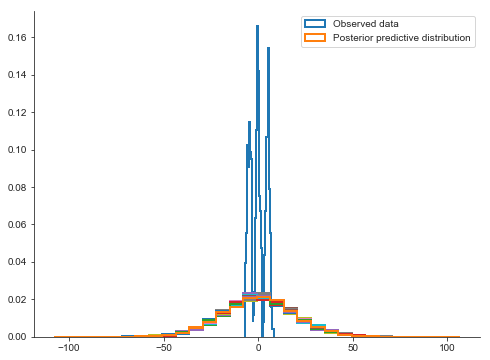

In [86]:

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(data, bins=30, density=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['obs'], bins=30, density=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


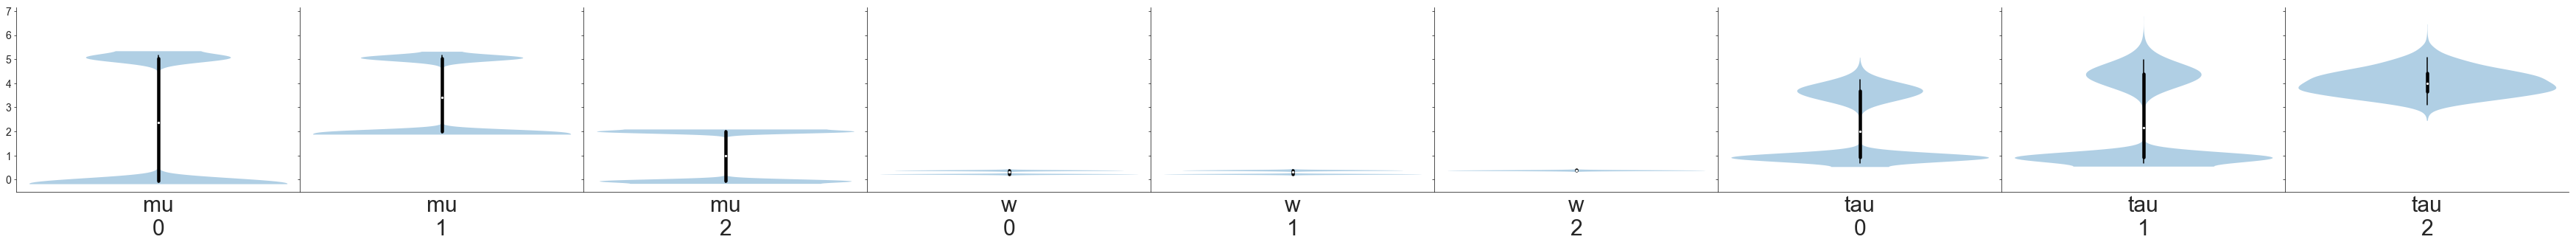

In [91]:
az.plot_violin(trace);